# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In this notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

Dataset Link: https://www.kaggle.com/murali0861/cxrdata


## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [1]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
DATASET_PATH = './CXR_data'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

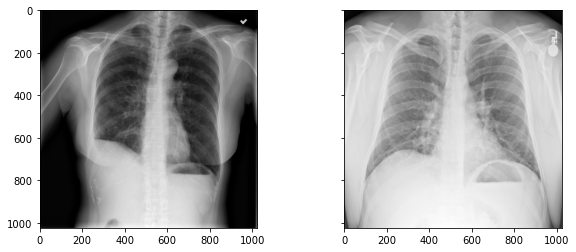

In [3]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [4]:
effusion.shape

(1024, 1024)

In [5]:
normal.shape

(1024, 1024)

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

In [22]:
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    ## Normalization
    img = (img - img.min())/(img.max() - img.min())
    ## Since it is an x-ray image, you can not do cropping of images. 
    ## As entire x-ray is large resolution, so we can do rescaling image to train model
    ## Remember, reducing resolution will loose some information, but it is ok for this use case
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    ## Here we are doing augmentation to randomly selected few images but not to all images
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously). 

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [21]:
import resnet

img_channels = 1  ## x-rays are gray scale images
img_rows = 256
img_cols = 256

nb_classes = 2

In [9]:
import numpy as np
import keras

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

In the previous notebook, you learnt about Ablation. Briefly, an ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [10]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1)

Epoch 1/1
1/1 [==============================] - 18s 18s/step - loss: 1.5026 - accuracy: 0.8667


In [11]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=5)

Epoch 1/5
1/1 [==============================] - 18s 18s/step - loss: 1.4849 - accuracy: 0.9000
Epoch 2/5
1/1 [==============================] - 7s 7s/step - loss: 1.4006 - accuracy: 0.9032
Epoch 3/5
1/1 [==============================] - 7s 7s/step - loss: 1.3527 - accuracy: 0.9032
Epoch 4/5
1/1 [==============================] - 6s 6s/step - loss: 1.2322 - accuracy: 0.9677
Epoch 5/5
1/1 [==============================] - 6s 6s/step - loss: 1.2933 - accuracy: 0.9032


**We can see that with accuracy our model looks like doing very good. But this might not be the case as data is highly imbalanced for both the classes 1:10. In this case, if model start predicting everything to a class, then it will reach to 90% accuracy which is not the correct measure. So, the objective to correctly classify the 'effusion'  is not fulfilled. The high accuracy clearly misleads us and therefore we will use AUC to validate the result.**


### Lets check this by training model and see validation accuracy

In [14]:
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs):
        logs = {}
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [15]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=5, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - 49s 10s/step - loss: 1.4888 - accuracy: 0.7372 - val_loss: 5.9839 - val_accuracy: 0.1250

Val AUC for epoch0: 0.5803571428571429
Epoch 2/5
5/5 [==============================] - 35s 7s/step - loss: 1.2947 - accuracy: 0.9032 - val_loss: 1.6077 - val_accuracy: 0.7500

Val AUC for epoch1: 0.3833333333333333
Epoch 3/5
5/5 [==============================] - 35s 7s/step - loss: 1.2602 - accuracy: 0.9097 - val_loss: 1.3185 - val_accuracy: 0.9375

Val AUC for epoch2: 0.6833333333333333
Epoch 4/5
5/5 [==============================] - 34s 7s/step - loss: 1.2806 - accuracy: 0.8968 - val_loss: 1.2427 - val_accuracy: 0.9375

Val AUC for epoch3: 0.375
Epoch 5/5
5/5 [==============================] - 34s 7s/step - loss: 1.2882 - accuracy: 0.8968 - val_loss: 1.4086 - val_accuracy: 0.8750

Val AUC for epoch4: 0.4482758620689655


### From the validation accuracy, we can clearly see that model is not working on validation data. 

* The model is not performing very well on AUC, the measure we had chosen. 
* The main reason for this is the prevalence problem. There are just not as many abnormal cases available in the dataset. This problem will occur in almost all medical imaging problems (and for that matter, in most datasets that have a class imbalance)
* To tackle this problem, we introduced 'weighted categorical cross-entropy'. This is a measure of loss, which applies weights to different forms of errors.


### Weighted Cross-Entropy

A common solution to the low prevalence rate problem is using a weighted cross-entropy loss. The loss is modified such that misclassifications of the low-prevalence class are penalised more heavily than the other class.

Therefore, every time the model makes an error on the abnormal class (in this case, ‘effusion’), we penalise it heavily by multiplying the loss by a high value of weights. This results in an increase in loss for misclassified classes and therefore the change in weights due to backpropagation is more. So, the learning curve for the weights responsible for misclassification is more. 

Let’s say “no finding” is class 0 and “effusion” is class 1.

    bin_weights[0,0]:  Actual class: 0, Predicted class: 0, so no penalty, just normal weight of 1. 

    bin_weights[1,1]:  Actual class: 1, Predicted class: 1, so no penalty, just normal weight of 1. 


In case of abnormality: 

    bin_weights[1,0] - Actual class is 1, Predicted class is 0, penalise by weight of 5.

    bin_weights[0,1] - Actual class is 0, Predicted class is 1, penalise by weight of 5.
    
    
External reference: 
https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607


In [23]:
## Implementation of weighted categorical cross entropy

from functools import partial
import keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [17]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=1)

Epoch 1/1
1/1 [==============================] - 18s 18s/step - loss: 4.1474 - accuracy: 0.2812


## 4. Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [18]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

We save the model weights only when there is an increase in 'validation accuracy'. The method to save the model weights is called checkpointing and it is called using keras callback. 

In [20]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

auc_logger = roc_callback()
filepath = 'best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
13/13 [==============================] - 119s 9s/step - loss: 2.3046 - accuracy: 0.3910 - val_loss: 10.3023 - val_accuracy: 0.8854

Val AUC for epoch0: 0.5606641123882503

Epoch 00001: val_auc improved from -inf to 0.56066, saving model to best_model.hdf5
Epoch 2/10
13/13 [==============================] - 98s 8s/step - loss: 2.1549 - accuracy: 0.6432 - val_loss: 2.2034 - val_accuracy: 0.9062

Val AUC for epoch1: 0.4686046511627907

Epoch 00002: val_auc did not improve from 0.56066
Epoch 3/10
13/13 [==============================] - 99s 8s/step - loss: 2.1065 - accuracy: 0.5990 - val_loss: 4.5889 - val_accuracy: 0.8958

Val AUC for epoch2: 0.5058139534883721

Epoch 00003: val_auc did not improve from 0.56066
Epoch 4/10
13/13 [==============================] - 93s 7s/step - loss: 2.1332 - accuracy: 0.6558 - val_loss: 2.8811 - val_accuracy: 0.8854

Val AUC for epoch3: 0.5568326947637292

Epoch 00004: val_auc did not improve from 0.56066
Epoch 5/10
13/13 [======================

## 5. Making a Prediction

In [ ]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('best_model.hdf5')

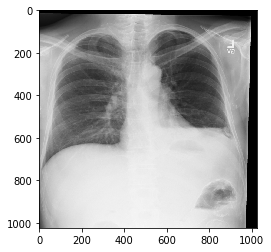

In [55]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-8])
plt.imshow(effusion,cmap='gray')

In [56]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

array([[0.36457857, 0.63542145]], dtype=float32)